# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tags pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre à l'exploration des données brutes. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
import re
from sklearn.preprocessing import MultiLabelBinarizer
import collections

# Déclaration de variables 

data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

# Chargement et découverte des données brutes

In [3]:
all_files = glob.glob(os.path.join(data_path, "QueryResults*.csv")) 

li = []

for absolute_filename in all_files:
    path, file = os.path.split(absolute_filename)
    df = pd.read_csv(absolute_filename, sep=',', encoding='utf-8', engine='python', error_bad_lines=False)
    li.append(df)

df_brut = pd.concat(li, axis=0, ignore_index=True)

print('Taille du CSV importé : {0}'.format(df_brut.shape))

print(pd.DataFrame(df_brut.dtypes, columns=['Type']))

Taille du CSV importé : (91947, 6)
         Type
Id     int64 
Name   object
Score  int64 
Body   object
Title  object
Tags   object


In [4]:
df_brut.to_pickle("./df_brut.pkl")

Les données extraites ciblent uniquement les posts de type "Question" dont les Id sont compris entre 0 et 600000.

In [5]:
df_brut = pd.read_pickle('./df_brut.pkl')

# Pandas Profiling

In [6]:
profile = df_brut.profile_report(title='Pandas Profiling Report', style={'full_width':True})
profile.to_file(output_file="output.html")

Aucune valeur manquante dans BODY, TITLE et TAGS

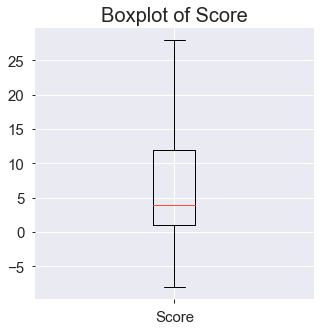

In [7]:
import matplotlib.pyplot as plt

# Boxplot of the variable Score
plt.figure(figsize=(5, 5))
plt.title("Boxplot of Score", fontsize=20)

# Boxplot without showing the outliers 
plt.xticks(size=15)
plt.yticks(size=15)
plt.boxplot(df_brut["Score"], showfliers=False, labels=['Score'])
plt.style.use('fivethirtyeight')
plt.show()

In [8]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

In [9]:
posts_tags = df_brut[df_brut.Score >= 3]['Tags']
posts_body = df_brut[df_brut.Score >= 3]['Body']
print("Nombre de posts :", posts_tags.shape[0])

Nombre de posts : 55598


# Analyse de la variable TAGS

In [10]:
posts_tags.head(5)

0    <c#><floating-point><type-conversion><double><decimal>
1    <html><css><internet-explorer-7>                      
2    <c#><.net><datetime>                                  
3    <c#><datetime><time><datediff><relative-time-span>    
4    <html><browser><timezone><user-agent><timezone-offset>
Name: Tags, dtype: object

In [11]:
# création d'un ensemble contenant tous les tags à partir des données du dataframe
# l'avantage d'un ensemble, c'est qu'un élément ne peut s'y trouver que 0 ou 1 fois 

set_tags = set() 

for list_keywords in (posts_tags.str.split('>').values):       
    # je rétablis le séparateur utilisé pour séparer les tags
    list_keywords.remove('')
    list_keywords = [keyword[1:] for keyword in list_keywords] 
    set_tags = set_tags.union(list_keywords)

print('There are %d tags' % len(set_tags))

There are 9712 tags


In [12]:
print(sorted(set_tags)[1750:1800])
# D est un langage de programmation

['currying', 'curses', 'cursor', 'cursor-position', 'cursor.current', 'cursors', 'curve', 'curve-fitting', 'curvesmoothing', 'custom-action', 'custom-attributes', 'custom-build-step', 'custom-component', 'custom-controls', 'custom-cursor', 'custom-draw', 'custom-error-pages', 'custom-errors', 'custom-exceptions', 'custom-linq-providers', 'custom-object', 'custom-protocol', 'custom-sections', 'custom-server-controls', 'custom-url-protocol', 'customization', 'custompaging', 'customtool', 'customvalidator', 'cut', 'cvs', 'cwd', 'cx-oracle', 'cxf', 'cycle', 'cyclic-reference', 'cyclomatic-complexity', 'cygwin', 'cython', 'd', 'd-star', 'daab', 'dabo', 'daemon', 'dailybuilds', 'dalvik', 'dao', 'darcs', 'darwin', 'dasblog']


In [13]:
print(sorted(set_tags)[5500:5600])
# nt = windows nt

['nod32', 'node.js', 'nodebox', 'nodelist', 'nodes', 'nodesets', 'nodester', 'nodevalue', 'nofollow', 'nohup', 'nokia', 'nomenclature', 'non-clustered-index', 'non-deterministic', 'non-greedy', 'non-lazy-ptr', 'non-nullable', 'non-printable', 'non-printing-characters', 'non-recursive', 'non-relational-database', 'non-scrolling', 'non-static', 'non-virtual-interface', 'non-well-formed', 'nonatomic', 'nonblank', 'nonblocking', 'nonclient', 'nonlinear-functions', 'normal-distribution', 'normalization', 'normalize', 'normalizing', 'noscript', 'nose', 'nosql', 'nosuchmethoderror', 'not-exists', 'not-operator', 'notation', 'notepad', 'notepad++', 'nothing', 'notification-bar', 'notifications', 'notify', 'notifyicon', 'notimplementedexception', 'notin', 'notnull', 'notsupportedexception', 'novell', 'novell-idm', 'noweb', 'np-complete', 'np-hard', 'npapi', 'nptl', 'nrpe', 'nsarray', 'nsarraycontroller', 'nsautoreleasepool', 'nscell', 'nscoding', 'nsdata', 'nsdate', 'nsdateformatter', 'nsdecima

In [14]:
posts_tags.loc[posts_tags.str.contains('<d>')].head(10)

5145     <d>                                                                
9336     <memory><memory-management><d><garbage-collection>                 
15091    <multithreading><performance><d><thread-local-storage>             
18400    <c><performance><d><standard-library>                              
20945    <.net><interop><d>                                                 
24157    <arrays><d><dmd>                                                   
28225    <performance><multithreading><optimization><parallel-processing><d>
32839    <d><popularity>                                                    
36866    <editor><d>                                                        
37683    <input><d><tango>                                                  
Name: Tags, dtype: object

In [15]:
# je compte les occurrences de chaque tag dans le dataframe
alltags_count = dict()
for s in set_tags: 
    #print(s)
    alltags_count[s] = posts_tags.str.count(re.escape(s)).sum() 

In [16]:
alltags_count = sorted(alltags_count.items(), key=lambda x: x[1], reverse=True)

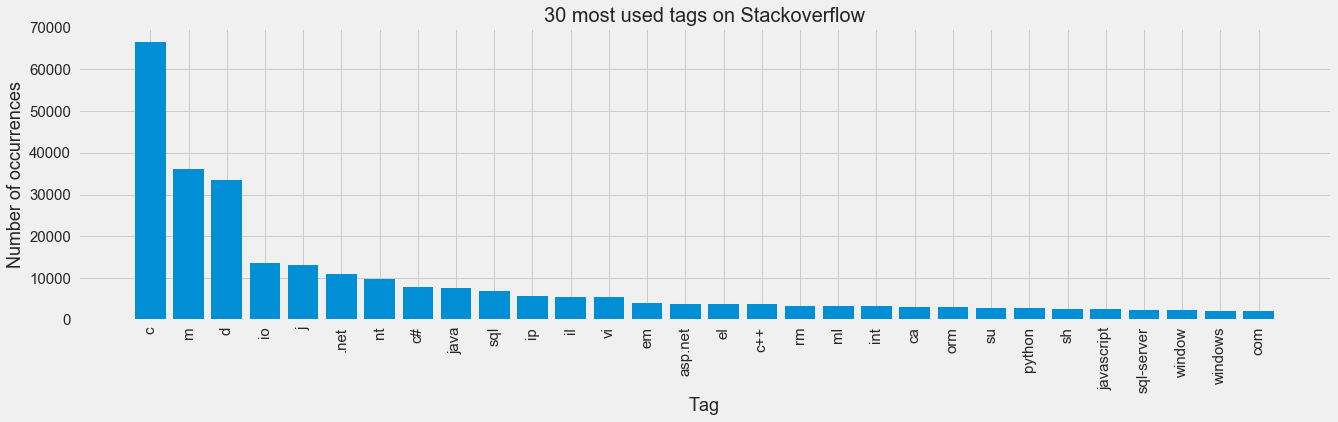

In [17]:
import matplotlib.pyplot as plt
# Graphique des 30 tags les plus utilisés sur Stackoverflow

top30tags = alltags_count[1:31]

plt.figure(figsize=(20, 5))
y_axis = [i[1] for i in top30tags]
label_x = [i[0] for i in top30tags]
ax = plt.axes()
plt.bar(label_x, y_axis)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("30 most used tags on Stackoverflow",fontsize=20)
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Number of occurrences', fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

### Nombre de posts impactés par les 100 à 1000 premiers tags

In [18]:
nb_posts_targeted = dict() 

for nb_top_tags in np.linspace(100, 1000, 10, dtype='int'):

    top_tags = [i[0] for i in alltags_count[1:nb_top_tags+1]]
    nb_posts_targeted[nb_top_tags] = 0
    
    for _tags in posts_tags.str.split('>'):
        _tags.remove('')
        _tags = [_tag[1:] for _tag in _tags] 
        for _tag in _tags:
            if _tag in top_tags:
                nb_posts_targeted[nb_top_tags] += 1
                break

    percentage_posts = (nb_posts_targeted[nb_top_tags]/posts_tags.shape[0])*100
    print('With %d tags kept, %.2f %% of the posts are concerned ' % (nb_top_tags, percentage_posts))                        

With 100 tags kept, 74.32 % of the posts are concerned 
With 200 tags kept, 85.36 % of the posts are concerned 
With 300 tags kept, 89.90 % of the posts are concerned 
With 400 tags kept, 92.83 % of the posts are concerned 
With 500 tags kept, 94.19 % of the posts are concerned 
With 600 tags kept, 95.15 % of the posts are concerned 
With 700 tags kept, 96.19 % of the posts are concerned 
With 800 tags kept, 96.83 % of the posts are concerned 
With 900 tags kept, 97.28 % of the posts are concerned 
With 1000 tags kept, 97.62 % of the posts are concerned 


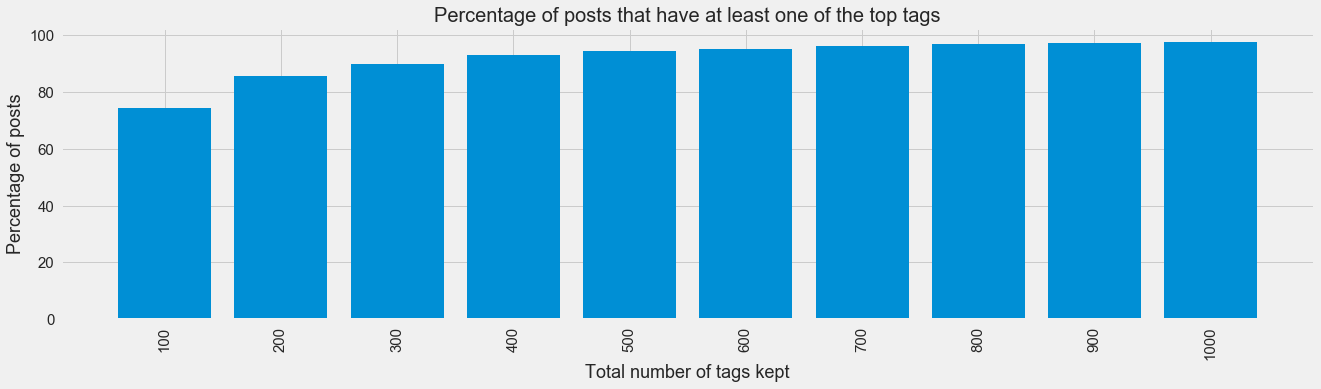

In [19]:
import matplotlib.pyplot as plt
# Graphique représentant le pourcentage de posts qui ont au moins un des top tags

plt.figure(figsize=(20, 5))
y_axis = [nb_posts_targeted[i]/posts_tags.shape[0]*100 for i in np.arange(100,1100, 100)]
label_x = [str(i) for i in np.arange(100,1100, 100)]
ax = plt.axes()
plt.bar(label_x, y_axis)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Percentage of posts that have at least one of the top tags",fontsize=20)
plt.xlabel('Total number of tags kept', fontsize=18)
plt.ylabel('Percentage of posts', fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

### Nombre de posts impactés par les 10 à 100 premiers tags

In [20]:
nb_posts_targeted = dict() 

for nb_top_tags in np.linspace(10, 100, 10, dtype='int'):

    top_tags = [i[0] for i in alltags_count[1:nb_top_tags+1]]
    nb_posts_targeted[nb_top_tags] = 0
    
    for _tags in posts_tags.str.split('>'):
        _tags.remove('')
        _tags = [_tag[1:] for _tag in _tags]        
        for _tag in _tags:
            if _tag in top_tags:
                nb_posts_targeted[nb_top_tags] += 1
                break

    percentage_posts = (nb_posts_targeted[nb_top_tags]/posts_tags.shape[0])*100
    print('With %d tags kept, %.2f %% of the posts are concerned ' % (nb_top_tags, percentage_posts))                        

With 10 tags kept, 32.79 % of the posts are concerned 
With 20 tags kept, 41.04 % of the posts are concerned 
With 30 tags kept, 53.19 % of the posts are concerned 
With 40 tags kept, 60.47 % of the posts are concerned 
With 50 tags kept, 62.75 % of the posts are concerned 
With 60 tags kept, 64.43 % of the posts are concerned 
With 70 tags kept, 67.63 % of the posts are concerned 
With 80 tags kept, 69.66 % of the posts are concerned 
With 90 tags kept, 72.50 % of the posts are concerned 
With 100 tags kept, 74.32 % of the posts are concerned 


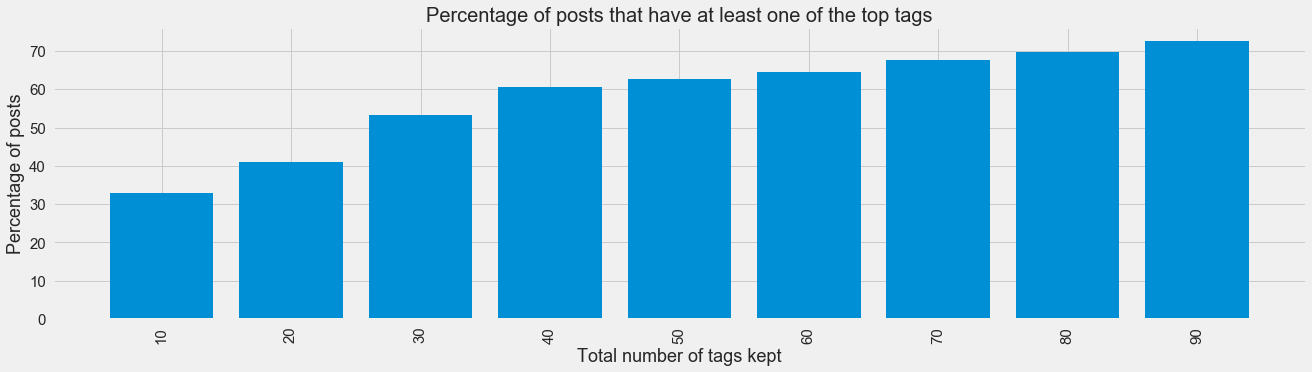

In [21]:
import matplotlib.pyplot as plt
# Graphique représentant le pourcentage de posts qui ont au moins un des top tags

plt.figure(figsize=(20, 5))
y_axis = [nb_posts_targeted[i]/posts_tags.shape[0]*100 for i in np.arange(10,100, 10)]
label_x = [str(i) for i in np.arange(10,100, 10)]
ax = plt.axes()
plt.bar(label_x, y_axis)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Percentage of posts that have at least one of the top tags",fontsize=20)
plt.xlabel('Total number of tags kept', fontsize=18)
plt.ylabel('Percentage of posts', fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

In [22]:
def most_common_tags(tags, top_tags, n_tags):
    ''' keep only the tags that are part of the top most used tags on StackOverflow
        filtered tags are sorted by order of appearance in top_tags list

    tags: tags associated to post
    top_tags: most_commonn tags
    n_tags: number of tags by sample
    '''
    
    clean_tags = tags.split('>')
    clean_tags.remove('')
    clean_tags = [_tag[1:] for _tag in clean_tags]     
    tags_filtered = []
    
    for _tag in clean_tags:
        if _tag in top_tags: 
            index = top_tags.index(_tag)
            tags_filtered.insert(index,_tag)    
    
    tags_filtered = tags_filtered[:n_tags]
    
    return tags_filtered

Je ne vais conserver qu'un nombre réduit de tags, d'une part, parce que c'est plus facile de prédire le bon tag à partir d'un nombre réduit de mots ; d'autre part, parce que dans les 10 000 tags, certains sont extrêmement confidentiels et spécifiques

### Top 100 tags = 74% des posts impactés
### Aucune limitation sur le nombre de tags par post

In [23]:
top100tags = [i[0] for i in alltags_count[1:101]]

print("Nombre de posts avant : {0}".format(posts_tags.shape[0]))

posts_top100tags = posts_tags.copy()
posts_top100tags = posts_top100tags.apply(lambda x: most_common_tags(x, top100tags, 5))
posts_top100tags = posts_top100tags.apply(lambda x: x if len(x)>0 else None)
posts_top100tags.dropna(inplace=True)

print('Nombre de posts après : {0}'.format(posts_top100tags.shape[0]))

Nombre de posts avant : 55598
Nombre de posts après : 41322


#### Fréquence des tags conservés 

In [24]:
toptags_count = [i[1] for i in alltags_count[1:101]]
toptags_count = pd.Series(toptags_count / sum(toptags_count) * 100, index=top100tags)
toptags_count.apply(lambda x: "{0:.2f}%".format(x))

c                18.82%
m                10.21%
d                9.44% 
io               3.82% 
j                3.75% 
.net             3.12% 
nt               2.77% 
c#               2.21% 
java             2.14% 
sql              1.95% 
ip               1.63% 
il               1.52% 
vi               1.52% 
em               1.17% 
asp.net          1.09% 
el               1.06% 
c++              1.04% 
rm               0.95% 
ml               0.94% 
int              0.92% 
ca               0.89% 
orm              0.85% 
su               0.82% 
python           0.81% 
sh               0.76% 
javascript       0.75% 
sql-server       0.68% 
window           0.64% 
windows          0.62% 
com              0.62% 
php              0.60% 
visual-studio    0.57% 
ase              0.55% 
ruby             0.53% 
ls               0.53% 
id               0.53% 
pi               0.50% 
html             0.49% 
sta              0.48% 
base             0.47% 
gin              0.44% 
database        

#### Nombre de tags par post et fréquence

In [25]:
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(posts_top100tags)
Y_sum = np.sum(Y,axis=1)
print([*collections.Counter(Y_sum).values()])
print([*collections.Counter(Y_sum).keys()])
print(Y.shape)

[26636, 11975, 2455, 244, 12]
[1, 2, 3, 4, 5]
(41322, 100)


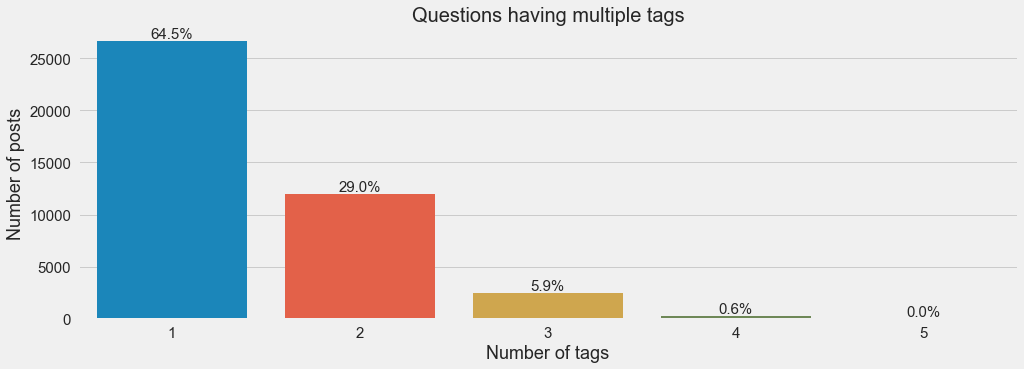

In [26]:
import matplotlib.pyplot as plt
# Nombre de tags par document
Y_n_tags = np.sum(multilabel_binarizer.fit_transform(posts_top100tags),axis=1)
# Fréquence du nombre de tags par document
multiLabel_counts = collections.Counter(Y_n_tags)
# clés 
# print([x[0] for x in multiLabel_counts.most_common()])
# valeurs 
# print([x[1] for x in multiLabel_counts.most_common()])
plt.figure(figsize=(15,5)) 
ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Questions having multiple tags",fontsize=20)
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
#adding the text labels
rects = ax.patches
labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
labels = ["{:0.1%}".format(x) for x in labels]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)
plt.style.use('fivethirtyeight')    
plt.show()

In [27]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

### Limitation à 3 tags par post

In [28]:
print("Nombre de posts avant : {0}".format(posts_tags.shape[0]))

posts_top100tags_3labels = posts_tags.copy()
posts_top100tags_3labels = posts_top100tags_3labels.apply(lambda x: most_common_tags(x, top100tags, 3))
posts_top100tags_3labels = posts_top100tags_3labels.apply(lambda x: x if len(x)>0 else None)
posts_top100tags_3labels.dropna(inplace=True)

print('Nombre de posts après : {0}'.format(posts_top100tags_3labels.shape[0]))

Nombre de posts avant : 55598
Nombre de posts après : 41322


#### Fréquence des tags conservés 

In [29]:
# je recompte les occurrences de chaque tag vu que j'en ai réduit le nombre
alltags_count_reduced = dict()
for s in top100tags: 
    alltags_count_reduced[s] = posts_top100tags_3labels.apply(lambda x: ','.join(map(str, x))).str.count(re.escape(s)).sum() 
alltags_count_reduced = sorted(alltags_count_reduced.items(), key=lambda x: x[1], reverse=True)    
toptags_count = [i[1] for i in alltags_count_reduced]
toptags_count = pd.Series(toptags_count / sum(toptags_count) * 100, index=top100tags)
toptags_count.apply(lambda x: "{0:.2f}%".format(x))

c                14.65%
m                7.15% 
d                6.37% 
io               5.92% 
j                5.59% 
.net             5.48% 
nt               3.60% 
c#               2.82% 
java             2.79% 
sql              2.60% 
ip               2.53% 
il               2.01% 
vi               1.99% 
em               1.69% 
asp.net          1.62% 
el               1.62% 
c++              1.55% 
rm               1.37% 
ml               1.33% 
int              1.11% 
ca               1.09% 
orm              1.04% 
su               0.95% 
python           0.92% 
sh               0.89% 
javascript       0.85% 
sql-server       0.85% 
window           0.84% 
windows          0.84% 
com              0.84% 
php              0.84% 
visual-studio    0.82% 
ase              0.81% 
ruby             0.77% 
ls               0.77% 
id               0.73% 
pi               0.72% 
html             0.72% 
sta              0.72% 
base             0.71% 
gin              0.71% 
database        

In [30]:
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(posts_top100tags_3labels)
Y_sum = np.sum(Y,axis=1)
print([*collections.Counter(Y_sum).values()])
print([*collections.Counter(Y_sum).keys()])
print(Y.shape)

[26636, 11975, 2711]
[1, 2, 3]
(41322, 100)


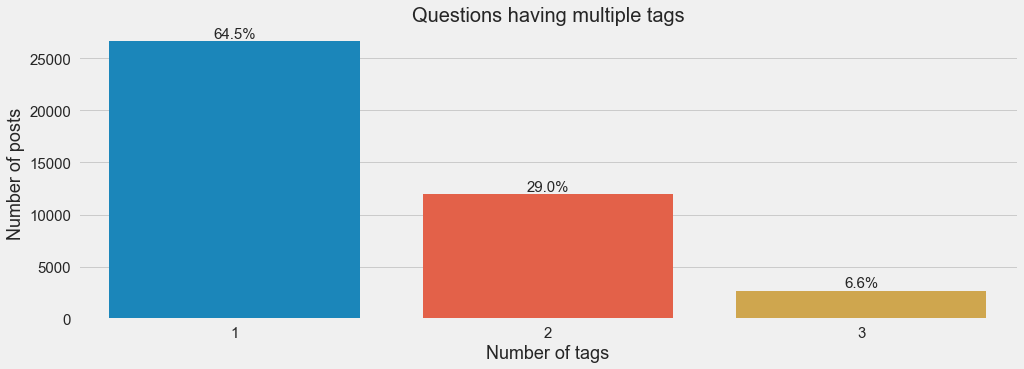

In [31]:
import matplotlib.pyplot as plt
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
# Nombre de tags par document
Y_n_tags = np.sum(multilabel_binarizer.fit_transform(posts_top100tags_3labels),axis=1)
# Fréquence du nombre de tags par document
multiLabel_counts = collections.Counter(Y_n_tags)
# clés 
# print([x[0] for x in multiLabel_counts.most_common()])
# valeurs 
# print([x[1] for x in multiLabel_counts.most_common()])
plt.figure(figsize=(15,5)) 
ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Questions having multiple tags",fontsize=20)
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
#adding the text labels
rects = ax.patches
labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
labels = ["{:0.1%}".format(x) for x in labels]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)
plt.style.use('fivethirtyeight')    
plt.show()

In [32]:
# SAUVEGARDE
top500tags = [i[0] for i in alltags_count[1:101]]
with open('top500tags.pkl', 'wb') as f:    
    pickle.dump(top500tags, f)
    
posts_body.to_pickle("./posts_body.pkl")
posts_top100tags.to_pickle("./posts_top100tags.pkl")
posts_top100tags_3labels.to_pickle("./posts_top100tags_3labels.pkl")